In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
from torch.utils.data import DataLoader

from evaluate.load.helpers import *
from evaluate.load.dataset import *
from evaluate.pipeline.model import *
from evaluate.pipeline.trainer import *
from evaluate.pipeline.embedding import *

In [2]:
def get_param(mode="paper",isHashEmbedding=True):
    return {"use_hash_embeddings": isHashEmbedding,
            "hashing_trick": True,
            "ngram_range": (1,9),
            "nFeaturesRange": (4,100),
            "embedding_size": 20,
            "num_buckets": 10**6,
            "max_features": 10**7,
            "max_epochs": 100,
            "num_hash_functions": 2,
            "hidden": 50,
            "seed": 123,
            "batch_size": 32,
            "masking":True,
            "append_weight":False,
            "validation_size":0.05,
            "patience":10,
            'cuda':True,
            'num_workers':4}
            
param = get_param()
seed = param['seed']
max_features = param['max_features']
ngram_range = param['ngram_range']
use_hash_embeddings = param['use_hash_embeddings']
isHashingTrick = param['hashing_trick']
num_buckets = param['num_buckets']
embedding_size = param['embedding_size']
max_epochs = param['max_epochs']
masking = param['masking']
append_weight = param['append_weight']
patience = param['patience']
num_hash_functions = param['num_hash_functions']
batch_size = param['batch_size']
validation_size = param['validation_size']
nFeaturesRange = param['nFeaturesRange']
isCuda = param['cuda']
num_workers = param['num_workers']

In [3]:
%%time

np.random.seed(seed)
torch.manual_seed(seed)

if isHashingTrick:
    train = AgNews(nFeaturesRange=nFeaturesRange,train=True,ngramRange=ngram_range,isHashingTrick=True,seed=seed)
    test = AgNews(nFeaturesRange=nFeaturesRange,train=False,ngramRange=ngram_range,isHashingTrick=True,seed=seed)
else:
    train = AgNews(nFeaturesRange=nFeaturesRange,num_words=max_features,train=True,ngram_range=ngram_range,isHashingTrick=False,seed=seed)
    test = AgNews(nFeaturesRange=nFeaturesRange,num_words=max_features,train=False,ngram_range=ngram_range,isHashingTrick=False,seed=seed,trainVocab=train.vocab)

CPU times: user 43.3 s, sys: 292 ms, total: 43.6 s
Wall time: 43.8 s


In [4]:
#train, valid = train_valid_load(train,validSize=0.1,isShuffle=True,seed=123,batch_size=batchSize)
test = DataLoader(dataset=test,batch_size=batch_size,shuffle=True)

In [5]:
num_classes = len(train.classes)
model = ModelNoDict(max_features,embedding_size,num_classes,isHash=True,num_buckets=num_buckets)
trainer = Trainer(model)
callbacks = [EarlyStopping(patience=param['patience'])]

In [ ]:
# bug with is hash = False

In [ ]:
%%time
trainer(train,callbacks=callbacks,validSize=validation_size)

Num parameters in model: 40000092
Train on 3563 samples, validate on 188 samples
Epoch: 0. Loss: 0.3889523446559906. Acc: 0.7891666666666667.
Epoch: 1. Loss: 0.22588536143302917. Acc: 0.8086666666666666.
Epoch: 2. Loss: 0.23749275505542755. Acc: 0.8146666666666667.
Epoch: 3. Loss: 0.1611558198928833. Acc: 0.8076666666666666.
Epoch: 4. Loss: 0.18009354174137115. Acc: 0.8148333333333333.
Epoch: 5. Loss: 0.0654757171869278. Acc: 0.8111666666666667.
Epoch: 6. Loss: 0.015526359900832176. Acc: 0.8111666666666667.
Epoch: 7. Loss: 0.33613213896751404. Acc: 0.8085.
Epoch: 8. Loss: 0.010806838981807232. Acc: 0.806.


In [ ]:
trainer.evaluate(test)

In [22]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.init import normal

class HashEmbedding(nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, num_buckets=None, num_hashes=2, train_sharedEmbed=True,
                 train_weight=True, append_weight=True, aggregation_mode='sum', mask_zero=False,seed=None):
        super(HashEmbedding, self).__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.num_hashes = num_hashes
        defaultNBuckets = (num_embeddings * self.num_hashes)//(self.embedding_dim)
        self.num_buckets = num_buckets - 1 if num_buckets is not None else defaultNBuckets
        self.train_sharedEmbed = train_sharedEmbed
        self.train_weight = train_weight
        self.append_weight = append_weight
        self.padding_idx = 0 if mask_zero else None
        self.seed = seed
        
        self.importance_weights = nn.Embedding(self.num_embeddings,
                                              self.num_hashes)
        self.shared_embeddings = nn.Embedding(self.num_buckets + 1,
                                            self.embedding_dim,
                                            padding_idx=self.padding_idx)
        self.hashes = None
        
        if aggregation_mode == 'sum':
            self.aggregate = lambda x: torch.sum(x, dim=-1)
        elif aggregation_mode == 'concatenate':
            # little bit quicker than permute/contiguous/view
            self.aggregate = lambda x: torch.cat([x[:,:,:,i] for i in range(self.num_hashes)], dim=-1) 
        elif aggregation_mode == 'mean':
            self.aggregate = lambda x: torch.mean(x, dim=-1)
        else:
            raise ValueError('unknown aggregation function {}'.format(aggregation_mode))
        
        self.output_dim = self.embedding_dim 
        if aggregation_mode == "concatenate":
            self.output_dim *= self.num_hashes
        if self.append_weight:
            self.output_dim += self.num_hashes
            
        self.reset_parameters()   
        
    def reset_parameters(self,
                        init_shared=lambda x: normal(x,std=0.1),
                        init_importance=lambda x: normal(x,std=0.0005)):
        """Resets the trainable parameters."""
        def set_constant_row(parameters,iRow=0,value=0):
            """Return `parameters` with row `iRow` as s constant `value`."""
            data = parameters.data
            data[iRow,:] = value
            return torch.nn.Parameter(data,requires_grad=parameters.requires_grad)

        np.random.seed(self.seed)
        if self.seed is not None:
            torch.manual_seed(self.seed)

        self.shared_embeddings.weight = init_shared(self.shared_embeddings.weight)
        self.importance_weights.weight = init_importance(self.importance_weights.weight)

        if self.padding_idx is not None:
            # Unfortunately has to set weight to 0 even when paddingIdx = 0
            self.shared_embeddings.weight = set_constant_row(self.shared_embeddings.weight)
            self.importance_weights.weight = set_constant_row(self.importance_weights.weight)

        self.shared_embeddings.weight.requires_grad = self.train_sharedEmbed
        self.importance_weights.weight.requires_grad = self.train_weight

        self.hashes = torch.from_numpy((np.random.randint(0, 2 ** 30,
                                                          size=(self.num_embeddings, self.num_hashes)
                                                         ) % self.num_buckets) + 1 
                                      ).type(torch.LongTensor)
        
    def _idx_hash(self, inputs, maxOutput, mask_zero=True):
        r"""Hash function for integers used to map indices of different sizes.
        
        Args:
            inputs (torch.Tensor): indices to hash.
            maxOutput (int): maximum integer to output. I.e size of table to access.
            mask_zero (bool,optional): whether should only map zero input to zero.
            
        To Do:
            Should enable :math:`\hat{D} \neq D_1`.
        """  
        if mask_zero:
            idx_zero = inputs == 0
            # shouldn't map non zero vectors to 0
            inputs = inputs%(maxOutput-1) + 1
            inputs[idx_zero] = 0
            return inputs
        else:
            return inputs%maxOutput
            
    def forward(self, input):  
        idx_hashes = self._idx_hash(input,self.num_embeddings,mask_zero=self.padding_idx is not None)
        idx_importance_weights = self._idx_hash(input,self.num_embeddings,mask_zero=False)
        idx_shared_embeddings = self.hashes[idx_hashes.data.cpu(),:]
        
        shared_embedding = torch.stack([self.shared_embeddings(idx_shared_embeddings[:,:,iHash]) 
                                        for iHash in range(self.num_hashes)], dim=-1)
        importance_weight = self.importance_weights(idx_importance_weights)
        importance_weight = importance_weight.unsqueeze(-2)
        word_embedding = self.aggregate(importance_weight*shared_embedding)
        if self.append_weight:
            # concateates the vector with the weights
            word_embedding = torch.cat([word_embedding,importance_weight.squeeze(-2)],dim=-1) 
        return word_embedding
    

In [24]:
h=HashEmbedding(10,3,5,2)

In [25]:
h.hashes


    2     3
    4     3
    4     4
    1     1
    4     1
    1     2
    1     1
    2     3
    1     4
    1     3
[torch.LongTensor of size 10x2]

In [27]:
l=[lambda x : 2*x,lambda x : 3*x]

In [ ]:
61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139,
    149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227,
    229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311,
    313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401,
    409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491,
    499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599,
    601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683,
    691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797,
    809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887,
    907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997)


In [ ]:
 1, 11, 13, 17, 19, 23, 29, 31, 37, 41,
   43, 47, 53, 59, 61, 67, 71, 73, 79, 83,
   89, 97,101,103,107,109,113,121,127,131,
  137,139,143,149,151,157,163,167,169,173,
  179,181,187,191,193,197,199,209

In [6]:
def next_prime(n):
    def is_prime(x):
        for i in range(2,int(np.sqrt(x))):
            if x % i == 0:
                return False
        return True
            
    while not is_prime(n):
        n += 1
    
    return n
        

In [7]:
next_prime(10**8)

100000007

In [241]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [252]:
class HashFamily():
    r"""Universal hash family as proposed by Carter and Wegman.
    
    .. math::

            \begin{array}{ll}
            h_{{a,b}}(x)=((ax+b)~{\bmod  ~}p)~{\bmod  ~}m \ \mid p > m\\
            \end{array}
    
    Args:
        bins (int): Number of bins to hash to. Better if a prime number.
        mask_zero (bool, optional): Whether the 0 input is a special "padding" value to mask out.
        moduler (int,optional): Temporary hashing. Has to be a prime number.
    """
    def __init__(self,bins,mask_zero=False,moduler=None):
        if moduler and moduler <= bins:
            raise ValueError("p (moduler) should be >> m (buckets)")
            
        self.bins = bins 
        self.moduler = moduler if moduler else self._next_prime(np.random.randint(self.bins+1,2**32))
        self.mask_zero = mask_zero
        
        # do not allow same a and b, as it could mean shifted hashes
        self.sampled_a = set()
        self.sampled_b = set()
    
    def _is_prime(self,x):
        """Naive is prime test."""
        for i in range(2,int(np.sqrt(x))):
            if x % i == 0:
                return False
        return True
        
    def _next_prime(self,n):  
        """Naively gets the next prime larger than n."""
        while not self._is_prime(n):
            n += 1

        return n
    
    def draw_hash(self,a=None,b=None):
        """Draws a single hash function from the family."""
        if a is None:
            while a is None or a in self.sampled_a:
                a = np.random.randint(1, self.moduler-1)
                assert len(self.sampled_a) < self.moduler-2, "please give a bigger moduler"
                
            self.sampled_a.add(a)
        if b is None:
            while b is None or b in self.sampled_b:
                b = np.random.randint(0, self.moduler-1)
                assert len(self.sampled_b) < self.moduler-1, "please give a bigger moduler"
                
            self.sampled_b.add(b)
        
        if self.mask_zero:
            return lambda x: 0 if x == 0 else ((a*x + b) % self.moduler) % (self.bins-1) + 1
        else:
            return lambda x: ((a*x + b) % self.moduler) % self.bins 
    
    def draw_hashes(self,n,**kwargs):
        """Draws n hash function from the family."""
        return [self.draw_hash() for i in range(n)]

In [265]:
py % 2

1.5

In [249]:
nn = 10**6
c = [s for s in string.ascii_letters[:26] + "   "]
randtext = "".join( (np.random.choice(c) for i in range(nn)) )
r = [hash(t) for t in randtext.split()]

In [254]:
b = 5

h = HashFamily(b,mask_zero=True)
hh = h.draw_hashes(2)

In [268]:
torch.Tensor([1,2,3,0,0]).apply_(hh[0])


 1
 2
 4
 0
 0
[torch.FloatTensor of size 5]

In [288]:
torch.stack([torch.Tensor([[1,2,3],[4,5,6],[0,0,0],[0,0,0]]).apply_(hhh) for hhh in hh],dim=-1)


(0 ,.,.) = 
  1  3
  2  2
  4  2

(1 ,.,.) = 
  1  1
  2  1
  4  4

(2 ,.,.) = 
  0  0
  0  0
  0  0

(3 ,.,.) = 
  0  0
  0  0
  0  0
[torch.FloatTensor of size 4x3x2]

In [280]:
a = torch.Tensor([1,2,3,0,0])
a.apply_(hh[0])


 1
 2
 4
 0
 0
[torch.FloatTensor of size 5]

In [281]:
a


 1
 2
 4
 0
 0
[torch.FloatTensor of size 5]

[]

[]

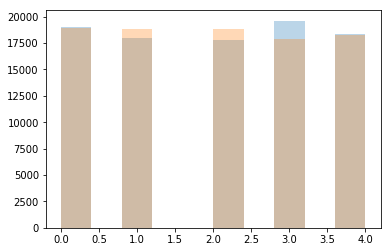

In [251]:
b = 10**3

h = HashFamily(b)
hh = h.draw_hashes(2)

arr2 = np.array([hh[0](i) for i in r])
_=plt.hist(arr2,alpha=0.3)

plt.plot()

arr1 = np.array([hh[1](i)%n for i in r])
_=plt.hist(arr1,alpha=0.3)

plt.plot()

In [ ]:
hh[0]()

$h_{{a,b}}(x)=((ax+b)~{\bmod  ~}p)~{\bmod  ~}m \ \mid p > m$

In [243]:
class HashFamily():
    r"""Universal hash family as proposed by Carter and Wegman.
    
    .. math::

            \begin{array}{ll}
            h_{{a,b}}(x)=((ax+b)~{\bmod  ~}p)~{\bmod  ~}m \ \mid p > m\\
            \end{array}
    
    Args:
        bins (int): Number of bins to hash to. Better if a prime number.
        moduler (int,optional): Temporary hashing. Has to be a prime number.
    """
    def __init__(self,bins,moduler=None):
        if moduler and moduler <= bins:
            raise ValueError("p (moduler) should be >> m (buckets)")
            
        self.bins = bins 
        self.moduler = moduler if moduler else self._next_prime(np.random.randint(self.bins+1,2**32))
        
        # do not allow same a and b, as it could mean shifted hashes
        self.sampled_a = set()
        self.sampled_b = set()
    
    def _is_prime(self,x):
        """Naive is prime test."""
        for i in range(2,int(np.sqrt(x))):
            if x % i == 0:
                return False
        return True
        
    def _next_prime(self,n):  
        """Naively gets the next prime larger than n."""
        while not self._is_prime(n):
            n += 1

        return n
    
    def draw_hash(self,a=None,b=None):
        """Draws a single hash function from the family."""
        if a is None:
            while a is None or a in self.sampled_a:
                a = np.random.randint(1, self.moduler-1)
                assert len(self.sampled_a) < self.moduler-2, "please give a bigger moduler"
                
            self.sampled_a.add(a)
        if b is None:
            while b is None or b in self.sampled_b:
                b = np.random.randint(0, self.moduler-1)
                assert len(self.sampled_b) < self.moduler-1, "please give a bigger moduler"
                
            self.sampled_b.add(b)
        
        return lambda x: ((a*x + b) % self.moduler) % self.bins
    
    def draw_hashes(self,n,**kwargs):
        """Draws n hash function from the family."""
        return [self.draw_hash() for i in range(n)]

In [231]:
h = HashFamily(3,5)

In [232]:
h.moduler

5

In [233]:
len(h.sampled_a)

0

In [234]:
H=h.draw_hashes(3)

In [235]:
for hh in H:
    print(hh(27),hh(28))

2 0
2 1
2 0


In [236]:
h.sampled_a

{1, 2, 3}